# Learning From Data Homework 8

In [3]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb

# Primal versus Dual Problem

# 1

N = size of data set  
d = dimensionality of input space  

The primal formulation of the hard-margin SVM problem is a quadratic programming problem where we find minimize with respect to (d+1) variables, and subject to N inequality constraints.

**Alternative 1D**

# SVM with Soft Margins

First download dataset.

```
wget http://www.amlbook.com/data/zip/features.train
wget http://www.amlbook.com/data/zip/features.test
```

Load and parse data into memory.

In [8]:
data_train = np.loadtxt("features.train")
print("data_train.shape", data_train.shape)

data_test = np.loadtxt("features.test")
print("data_test.shape", data_test.shape)

data_train[0:5,:]

data_train.shape (7291, 3)
data_test.shape (2007, 3)


array([[ 6.        ,  0.3410918 , -4.5289375 ],
       [ 5.        ,  0.44413086, -5.4968125 ],
       [ 4.        ,  0.23100195, -2.88675   ],
       [ 7.        ,  0.20027539, -3.534375  ],
       [ 3.        ,  0.29193555, -4.3520625 ]])

As described in the homework PDF, the columns are:

**digit, intensity, symmetry**

Take a quick look at the data.

First with seaborn.

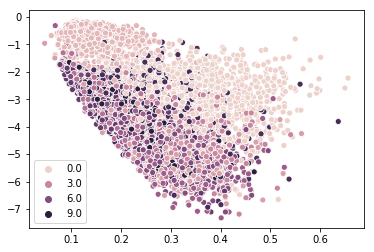

In [62]:
sb.scatterplot(data_train[:,1], data_train[:,2], data_train[:,0])
plt.show()

Then with matplotlib:

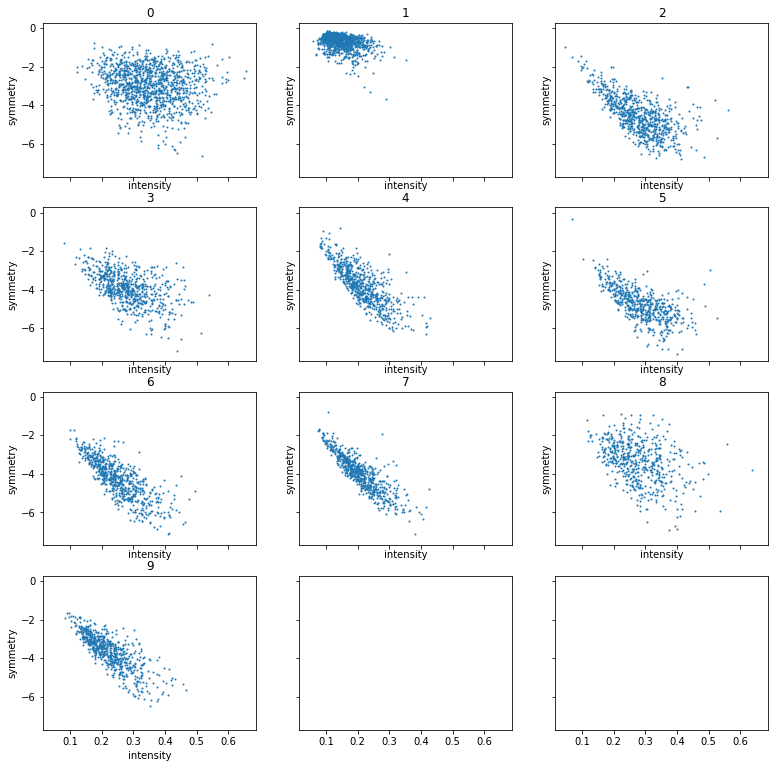

In [54]:
get_pos = lambda n: divmod(n, 3)
fig, ax = plt.subplots(4, 3, figsize=(13,13), sharex=True, sharey=True)

for n in range(10):
    i = np.where(data_train[:,0] == n)
    ax[get_pos(n)].scatter(data_train[i,1], data_train[i,2], s=1)
    ax[get_pos(n)].set_title(n)
    ax[get_pos(n)].set_xlabel("intensity")
    ax[get_pos(n)].set_ylabel("symmetry")

plt.show()

It does not look like we will be very successful with classifiying this data set based on only these two features. But let's try.

## Polynomial Kernels

Consider $$K(\mathbf x_n, \mathbf x_m) = (1 + \mathbf x_n^T \mathbf x_m)^Q$$

# 2

Let C=0.01 and Q=2. Find which classifier has the highest E_in for

* 0 vs all
* 2 vs all
* 4 vs all
* 6 vs all
* 8 vs all

---

Looking at the data, I would guess that 4 vs all has a high in-sample error due to its similarity with other classes. Let's see. 

Sklearn has a gamma coefficient for the polynomial which we don't need, so we will set this to 1.

 $$K(\mathbf x_n, \mathbf x_m) = (1 + \gamma\mathbf x_n^T \mathbf x_m)^Q$$

Define an utility method to get classification data sets for "n-vs-all" type of problems.

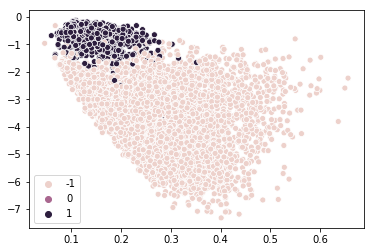

In [119]:
def get_n_vs_all_dataset(n, which="train"):
    if which == "train":
        data = data_train
    elif which == "test":
        data = data_test
    else:
        1/0
    is_n = data[:,0] == n
    is_not_n = data[:,0] != 0
    X = data.copy()
    X[:,0] = 1.0
    y = 2*is_n - 1
    return X, y

# Verify that the method is working like expected
X, y = get_n_vs_all_dataset(1)
sb.scatterplot(X[:,1], X[:,2], y)
plt.show()

# Looks good when comparing to scatterplot of 1's above.

In [120]:
from sklearn import svm

for n in (0, 2, 4, 6, 8):
    clf = svm.SVC(C=0.01, kernel="poly", degree=2, gamma=1.0)
    X, y = get_n_vs_all_dataset(n)
    clf.fit(X, y)
    y_predict = clf.predict(X)
    E_in = np.mean(y != y_predict)
    print(n, E_in)

0 0.10588396653408312
2 0.10026059525442327
4 0.08942531888629818
6 0.09107118365107666
8 0.07433822520916199


0 vs all has the highest in-sample error, **Alternative 2A**

# 3

In [128]:
for n in (1, 3, 5, 7, 9):
    clf = svm.SVC(C=0.01, kernel="poly", degree=2, gamma=1.0)
    X, y = get_n_vs_all_dataset(n)
    clf.fit(X, y)
    y_predict = clf.predict(X)
    E_in = np.mean(y != y_predict)
    print(n, E_in)

1 0.014401316691811822
3 0.09024825126868742
5 0.07625840076807022
7 0.08846523110684405
9 0.08832807570977919


1 vs all has the lowest in-sample error, **Alternative 3A**

# 4
Number of support vectors for the selected classifiers from problems 2 and 3. What is the difference between the number of support vectors?

In [129]:
clf = svm.SVC(C=0.01, kernel="poly", degree=2, gamma=1.0)
X, y = get_n_vs_all_dataset(0)
clf.fit(X, y)
a_num = len(clf.support_)
print("0 vs all support vecs:", a_num)

clf = svm.SVC(C=0.01, kernel="poly", degree=2, gamma=1.0)
X, y = get_n_vs_all_dataset(1)
clf.fit(X, y)
b_num = len(clf.support_)
print("1 vs all support vecs:", b_num)

print("difference:", a_num - b_num)

0 vs all support vecs: 2179
1 vs all support vecs: 386
difference: 1793


**Alternative 4C**, 1800

# 5

Let's make a small utility method to a one vs one dataset.

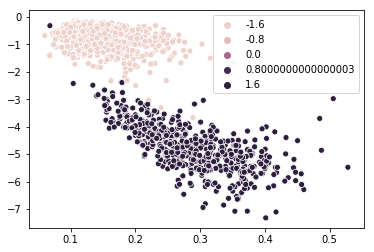

In [123]:
def get_n_vs_m_dataset(n, m, which="train"):
    """y is 1 for n and -1 for m."""
    if which == "train":
        data = data_train
    elif which == "test":
        data = data_test
    else:
        1/0
    is_n = data[:,0] == n
    is_m = data[:,0] == m
    relevant_data = data[np.logical_or(is_n, is_m)]
    X = relevant_data.copy()
    X[:,0] = 1.0
    y = relevant_data[:,0].copy()
    
    y[np.where(relevant_data[:,0] == n)] = 1
    y[np.where(relevant_data[:,0] == m)] = -1
    return X, y

X, y = get_n_vs_m_dataset(5, 1)

sb.scatterplot(X[:,1], X[:,2], y)
plt.show()

Train the 1-vs-5 classifier.

In [124]:
X_train, y_train = get_n_vs_m_dataset(1, 5, "train")
X_test, y_test = get_n_vs_m_dataset(1, 5, "test")
for C in (0.001, 0.01, 0.1, 1):
    clf = svm.SVC(C=C, kernel="poly", degree=2, gamma=1.0)
    clf.fit(X_train, y_train)
    nvecs = len(clf.support_)
    E_in = np.mean(clf.predict(X_train) != y_train)
    E_out = np.mean(clf.predict(X_test) != y_test)

    print("C={}, supportvecs={}, Ein={}, Eout={}".format(C, nvecs, E_in, E_out))
    

C=0.001, supportvecs=76, Ein=0.004484304932735426, Eout=0.01650943396226415
C=0.01, supportvecs=34, Ein=0.004484304932735426, Eout=0.018867924528301886
C=0.1, supportvecs=24, Ein=0.004484304932735426, Eout=0.018867924528301886
C=1, supportvecs=24, Ein=0.0032030749519538757, Eout=0.018867924528301886


a: nvecs goes down as C goes up. False, it stays constant for 0.1 to 1.  
b: nvecs goes up as C goes up. False  
c: Eout goes down when C goes up. False, it goes up.  
d: Maxiumum C achieves lowest Ein.  True.  

**Alternative 5D**

# 6

Comparison with exercise 5 using Q=5.

In [127]:
X_train, y_train = get_n_vs_m_dataset(1, 5, "train")
X_test, y_test = get_n_vs_m_dataset(1, 5, "test")
for C in (0.0001, 0.001, 0.010, 0.1):
    clf2 = svm.SVC(C=C, kernel="poly", degree=2, gamma=1.0)
    clf2.fit(X_train, y_train)
    nvecs2 = len(clf2.support_)
    E_in2 = np.mean(clf2.predict(X_train) != y_train)
    E_out2 = np.mean(clf2.predict(X_test) != y_test)
    clf5 = svm.SVC(C=C, kernel="poly", degree=5, gamma=1.0)
    clf5.fit(X_train, y_train)
    nvecs5 = len(clf5.support_)
    E_in5 = np.mean(clf5.predict(X_train) != y_train)
    E_out5 = np.mean(clf5.predict(X_test) != y_test)

    print("C={}, vecs2={}, vecs5={}, Ein2={:f}, Ein5={:f}, Eout2={:f}, Eout5={:f}".format(C, nvecs2, nvecs5, E_in2, E_in5, E_out2, E_out5))
    

C=0.0001, vecs2=236, vecs5=26, Ein2=0.008969, Ein5=0.004484, Eout2=0.016509, Eout5=0.018868
C=0.001, vecs2=76, vecs5=25, Ein2=0.004484, Ein5=0.004484, Eout2=0.016509, Eout5=0.021226
C=0.01, vecs2=34, vecs5=23, Ein2=0.004484, Ein5=0.003844, Eout2=0.018868, Eout5=0.021226
C=0.1, vecs2=24, vecs5=25, Ein2=0.004484, Ein5=0.003203, Eout2=0.018868, Eout5=0.018868


a: C=0.0001, Ein is higher at Q=5: False  
b: C=0.001, nvecs is lower at Q=5: True  
c: C=0.01, Ein is higher at Q=5:  False   
d: C=1, Eout is lower at Q=5:  False,  

**Alternative 6 B**

A little gotcha here: If you forgot to add the intercept (1 column) to the input data, there will be multiple correct alternatives.

# Cross Validation

# 7

Q=2, 1 vs 5 classifier. Choose best C by using 10 fold cross validation.
Within {0.0001, 0.001, 0.01, 0.1, 1}. For ties, choose smallest C.

In [170]:
from collections import defaultdict

X, y = get_n_vs_m_dataset(1, 5, "train")

def argmin(d):
    m = 999
    arg = 0
    for C in (0.0001, 0.001, 0.01, 0.1, 1):
        if d[C] < m:
            m = d[C]
            arg = C
    return arg

selected = defaultdict(int)
all_E_cvs = []
winning_E_cvs = []
for i in range(100):
    kfold = sk.model_selection.KFold(n_splits=10, shuffle=True)
    E_cvs = defaultdict(float)
    for itrain, itest in kfold.split(X):
        for C in (0.0001, 0.001, 0.01, 0.1, 1):
            X_train, y_train = X[itrain,:], y[itrain]
            X_test, y_test = X[itest,:], y[itest]
            clf = svm.SVC(C=C, kernel="poly", degree=2, gamma=1.0)
            clf.fit(X_train, y_train)
            E_val = np.mean(clf.predict(X_test) != y_test)
            E_cvs[C] += E_val
    best_C = argmin(E_cvs)
    selected[best_C] += 1
    winning_E_cvs.append(E_cvs[best_C])
    print(selected)

print("avg winning Ecv over all runs", np.mean(winning_E_cvs))




defaultdict(<class 'int'>, {0.001: 1})
defaultdict(<class 'int'>, {0.001: 2})
defaultdict(<class 'int'>, {0.001: 3})
defaultdict(<class 'int'>, {0.001: 4})
defaultdict(<class 'int'>, {0.01: 1, 0.001: 4})
defaultdict(<class 'int'>, {0.01: 1, 0.001: 5})
defaultdict(<class 'int'>, {0.01: 1, 0.001: 6})
defaultdict(<class 'int'>, {0.01: 2, 0.001: 6})
defaultdict(<class 'int'>, {0.01: 2, 0.001: 7})
defaultdict(<class 'int'>, {0.1: 1, 0.01: 2, 0.001: 7})
defaultdict(<class 'int'>, {0.1: 1, 1: 1, 0.01: 2, 0.001: 7})
defaultdict(<class 'int'>, {0.1: 1, 1: 1, 0.01: 2, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 2, 1: 1, 0.01: 2, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 3, 1: 1, 0.01: 2, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 4, 1: 1, 0.01: 2, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 5, 1: 1, 0.01: 2, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 5, 1: 1, 0.01: 3, 0.001: 8})
defaultdict(<class 'int'>, {0.1: 5, 1: 1, 0.01: 3, 0.001: 9})
defaultdict(<class 'int'>, {0.1: 5, 1: 2, 0.01: 3, 0

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ooops: Only use the training data here. Don't use the test data.

**Alternative 7B: 0.001 is selected most often**

# 8

Around 0.0045. **Alternative 8C**

# RBF Kernel

# 9

In [171]:
X_train, y_train = get_n_vs_m_dataset(1, 5, "train")
X_test, y_test = get_n_vs_m_dataset(1, 5, "test")

for C in (0.01, 1, 100, 10000, 1000000):
    clf = svm.SVC(C=C, kernel="rbf", gamma=1.0)
    clf.fit(X_train, y_train)
    E_out = np.mean(clf.predict(X_test) != y_test)
    E_in = np.mean(clf.predict(X_train) != y_train)
    print(C, E_in, E_out)

0.01 0.003843689942344651 0.02358490566037736
1 0.004484304932735426 0.02122641509433962
100 0.0032030749519538757 0.018867924528301886
10000 0.0025624599615631004 0.02358490566037736
1000000 0.0006406149903907751 0.02358490566037736


**Alternative E, 1000000** results in the smallest E_in.

# 10

**Alternative C, 100** results in the smallest E_out.

# Bonus, plotting SVM boundaries

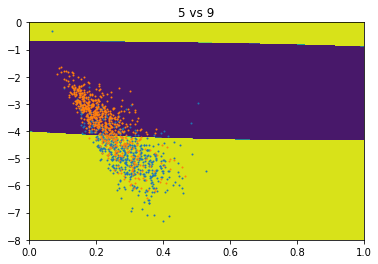

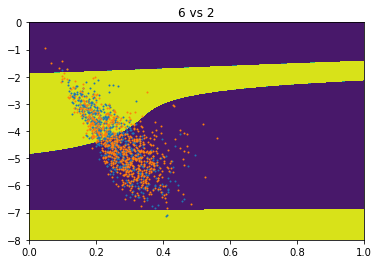

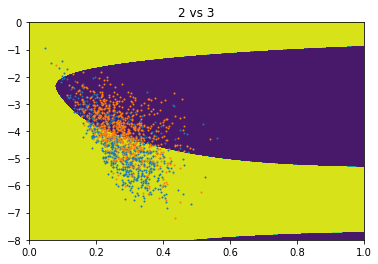

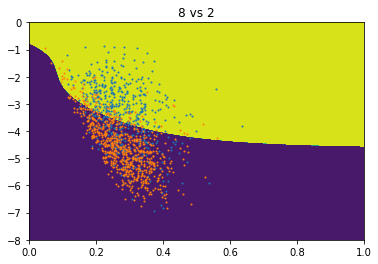

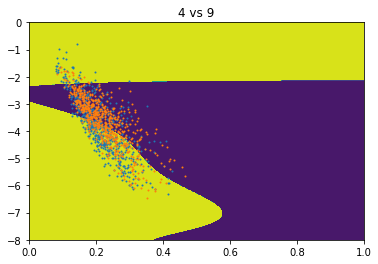

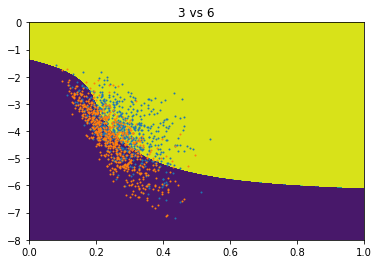

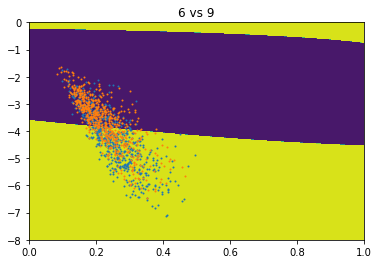

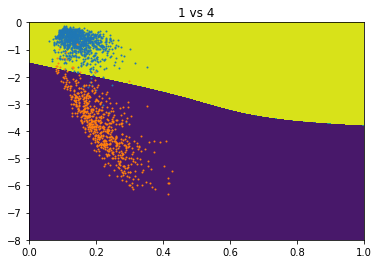

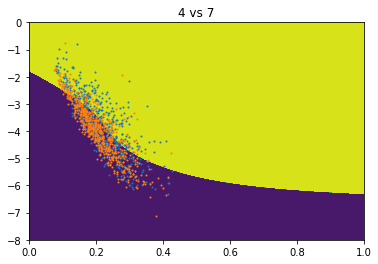

In [200]:
def plot_n_vs_m(n, m):
    X, y = get_n_vs_m_dataset(n, m, "train")
    clf = svm.SVC(C=10, kernel="rbf", gamma="auto")
    clf.fit(X, y)
    yy = np.linspace(-8, 0, 1000)
    xx = np.linspace(0, 1, 1000)
    XX, YY = np.meshgrid(xx, yy)
    Z = clf.predict(np.c_[np.ones(XX.ravel().shape[0]), XX.ravel(), YY.ravel()])
    ZZ = Z.reshape(XX.shape)
    plt.contourf(XX, YY, ZZ)
    is_n = np.where(y == 1)
    is_m = np.where(y == -1)
    plt.scatter(X[is_n,1], X[is_n,2], s=1)
    plt.scatter(X[is_m,1], X[is_m,2], s=1)
    plt.title("{} vs {}".format(n, m))
    plt.show()

for i in range(1, 10):
    n = np.random.randint(0, 10)
    m = np.random.randint(0, 10)
    if n == m:
        continue

    plot_n_vs_m(n, m)